In [72]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [66]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 35
IMG_HEIGHT = 180
IMG_WIDTH = 180

--2025-12-30 08:59:16--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.5’

cats_and_dogs.zip.5 100%[===================>]  67.43M   264MB/s    in 0.3s    

2025-12-30 08:59:16 (264 MB/s) - ‘cats_and_dogs.zip.5’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [67]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',  # test has only 1 folder but binary still works
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


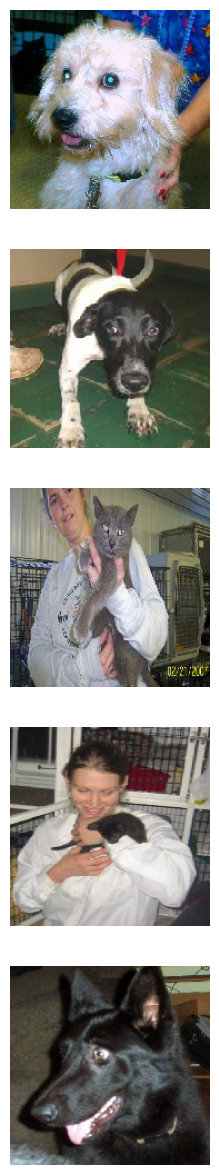

In [68]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [69]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


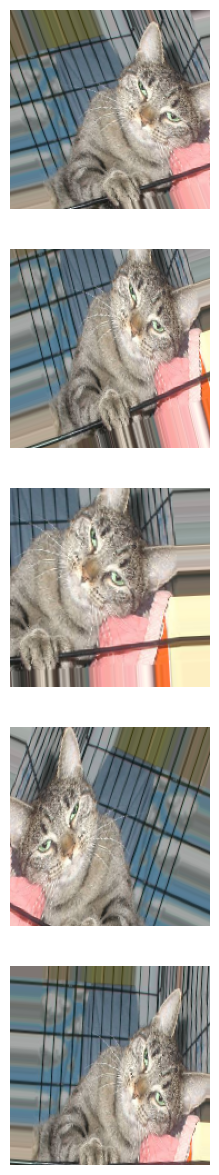

In [70]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [73]:
# 7
model = Sequential([
    # 1st Conv block
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 2nd Conv block
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 3rd Conv block
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 4th Conv block
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    optimizer='adam',               # Adam optimizer works well for CNNs
    loss='binary_crossentropy',     # binary crossentropy for 2 classes
    metrics=['accuracy']            # track accuracy
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,008,193 (41.99 MB)

 Trainable params: 11,007,233 (41.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [74]:
# 8
# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=35,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5409 - loss: 6.8175 - val_accuracy: 0.4676 - val_loss: 0.7379 - learning_rate: 0.0010
Epoch 2/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5781 - loss: 1.7054 - val_accuracy: 0.4743 - val_loss: 0.8175 - learning_rate: 0.0010
Epoch 3/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5548 - loss: 1.2700 - val_accuracy: 0.5513 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 4/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.5859 - loss: 0.8167 - val_accuracy: 0.5179 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 5/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5732 - loss: 0.8697 - val_accuracy: 0.4978 - val_loss: 0.7194 - learning_rate: 0.0010
Epoch 6/35
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.5078 - loss: 0.7828
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5078 - loss: 0.7828 - val_acc

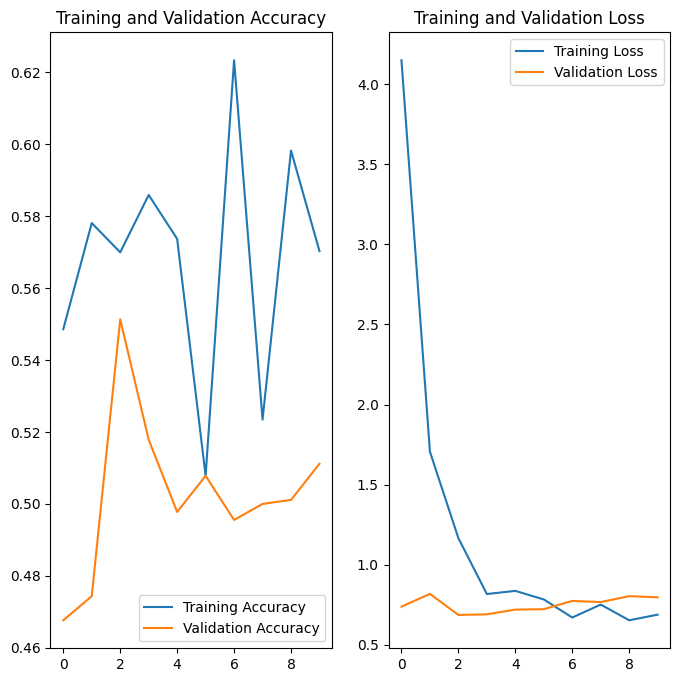

In [76]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


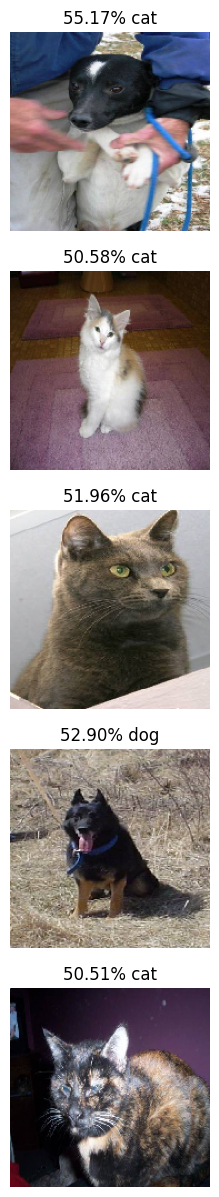

In [78]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# 1️⃣ Load and preprocess all test images
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
test_image_paths.sort() # Ensure consistent order

test_images_np = [] # This will store images ready for the model and plotting (0-1 scaled)

for img_path in test_image_paths:
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    # Rescale pixel values to 0-1 for model input and plotting
    test_images_np.append(img_array / 255.0)

test_images_np = np.array(test_images_np) # Convert list to numpy array

# Make predictions
# The variable name 'probabilities' is used in the next cell, so let's stick to it.
probabilities = model.predict(test_images_np).flatten()

# 2️⃣ Visualize predictions on first 5 test images
# Pass the original (but rescaled) images for plotting
plotImages(test_images_np[:5], probabilities=probabilities[:5])

In [80]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!


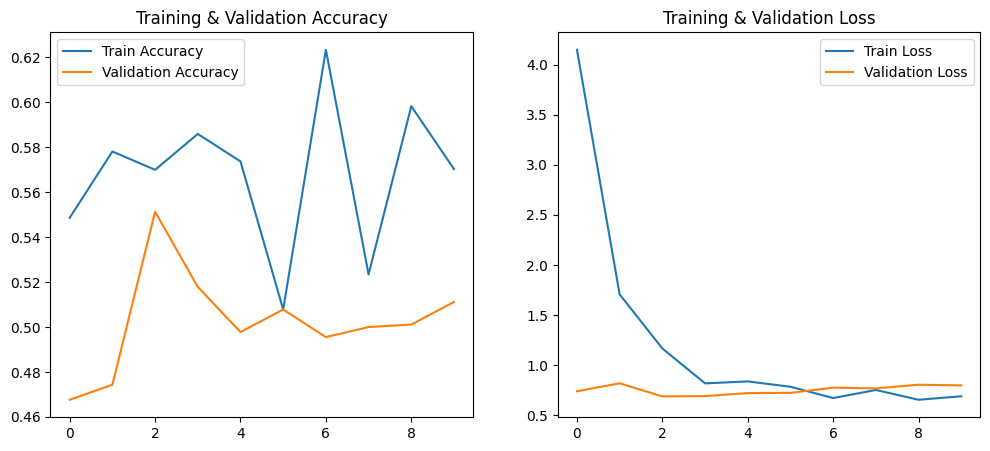

✅ Saved training accuracy & loss plot as images/accuracy_plot.png


<Figure size 500x1500 with 0 Axes>

✅ Saved first 5 test predictions as images/test_predictions.png


In [81]:
import os
import matplotlib.pyplot as plt

# 1️⃣ Create images folder if it doesn't exist
if not os.path.exists("images"):
    os.mkdir("images")

# 2️⃣ Save Training Accuracy & Loss Plot
plt.figure(figsize=(12,5))

# Accuracy subplot
plt.subplot(1,2,1)
plt.plot(range(len(acc)), acc, label='Train Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss subplot
plt.subplot(1,2,2)
plt.plot(range(len(loss)), loss, label='Train Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

# Save figure
plt.savefig("images/accuracy_plot.png")
plt.show()

print("✅ Saved training accuracy & loss plot as images/accuracy_plot.png")

# 3️⃣ Save First 5 Test Predictions
plt.figure(figsize=(5, 15))
for i, (img, prob) in enumerate(zip(all_test_images[:5], all_probabilities[:5])):
    plt.subplot(5,1,i+1)
    plt.imshow(img)
    plt.axis('off')
    label = "Dog" if prob > 0.5 else "Cat"
    plt.title(f"{label} ({prob*100:.2f}%)")

plt.tight_layout()
plt.savefig("images/test_predictions.png")
plt.show()

print("✅ Saved first 5 test predictions as images/test_predictions.png")
